# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Define the objective and problem

In [2]:
# first type of objective
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                               grad=sp.optimize.rosen_der, 
                               hess=sp.optimize.rosen_hess)

# second type of objective
def rosen2(x):
    return sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x)
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

dim_full = 10
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

### Illustration

In [3]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))     

Text(0.5, 0.92, 'cost function values')

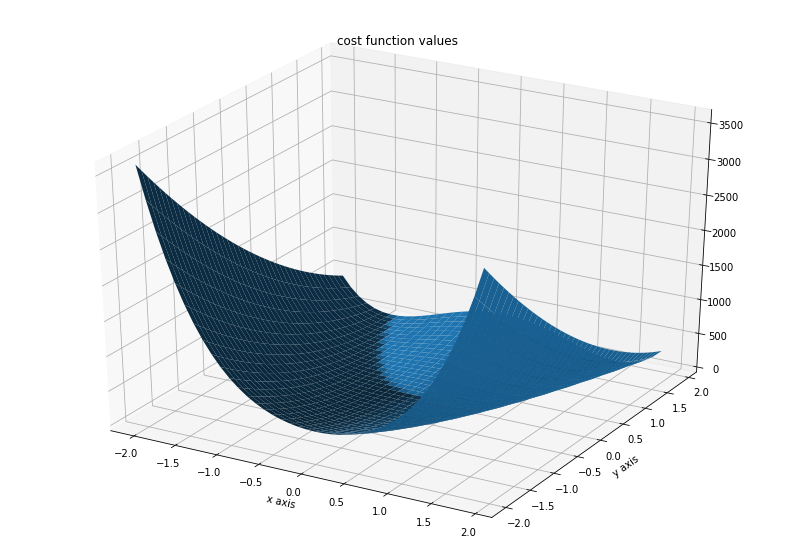

In [4]:
fig = plt.figure()
fig.set_size_inches(*(14,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)
plt.xlabel('x axis')
plt.ylabel('y axis')
ax.set_title('cost function values')

## Run optimization

In [5]:
%%time

# create different optimizers
optimizer_bfgs = pypesto.ScipyOptimizer(method='l-bfgs-b')
optimizer_tnc = pypesto.ScipyOptimizer(method='TNC')
optimizer_dogleg = pypesto.ScipyOptimizer(method='dogleg')

# set number of starts
n_starts = 20

# save optimizer trace
history_options = pypesto.HistoryOptions(trace_record=True)

# Run optimizaitons for different optimzers
result1_bfgs = pypesto.minimize(
    problem=problem1, optimizer=optimizer_bfgs,
    n_starts=n_starts, history_options=history_options)
result1_tnc = pypesto.minimize(
    problem=problem1, optimizer=optimizer_tnc,
    n_starts=n_starts, history_options=history_options)
result1_dogleg = pypesto.minimize(
    problem=problem1, optimizer=optimizer_dogleg,
    n_starts=n_starts, history_options=history_options)

# Optimize second type of objective
result2 = pypesto.minimize(problem=problem2, optimizer=optimizer_tnc, n_starts=n_starts)

Function values from history and optimizer do not match: 3.143508907828694, 4.160610487361178
Parameters obtained from history and optimizer do not match: [ 0.9797034   0.96093404  0.93289151  0.86570753  0.73909171  0.52956735
  0.23471801  0.04192688 -0.01122123  0.01035227], [ 0.96513728  0.92877591  0.84591693  0.70894513  0.48780217  0.20601383
  0.01919406  0.01182987  0.01070513 -0.0024258 ]
Function values from history and optimizer do not match: 3.772598558502893, 4.558893042797237
Parameters obtained from history and optimizer do not match: [0.96292743 0.92547199 0.85455392 0.7284939  0.52371225 0.26343137
 0.05594303 0.01111646 0.00928881 0.00167121], [0.94728756 0.89775573 0.80358762 0.63854016 0.37678432 0.10582846
 0.01315801 0.0093549  0.00628588 0.00314701]
Function values from history and optimizer do not match: 1.0274016923302407, 1.4214269598712324
Parameters obtained from history and optimizer do not match: [0.99677399 0.99183686 0.98225129 0.96328102 0.92647654 0.8

CPU times: user 4.96 s, sys: 216 ms, total: 5.17 s
Wall time: 5.13 s


### Visualize and compare optimization results

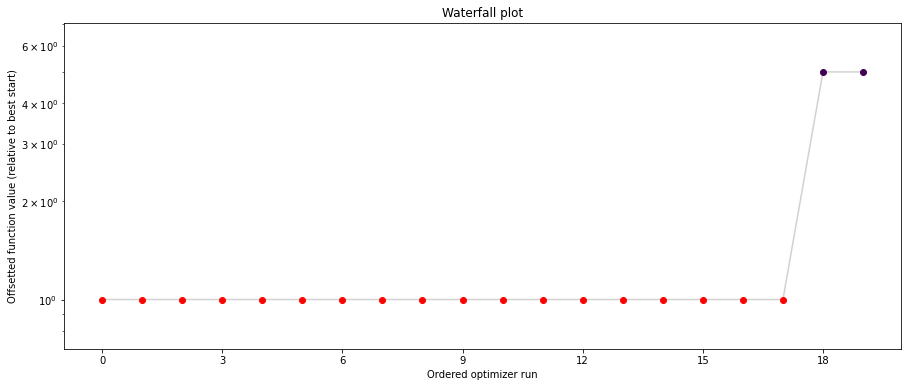

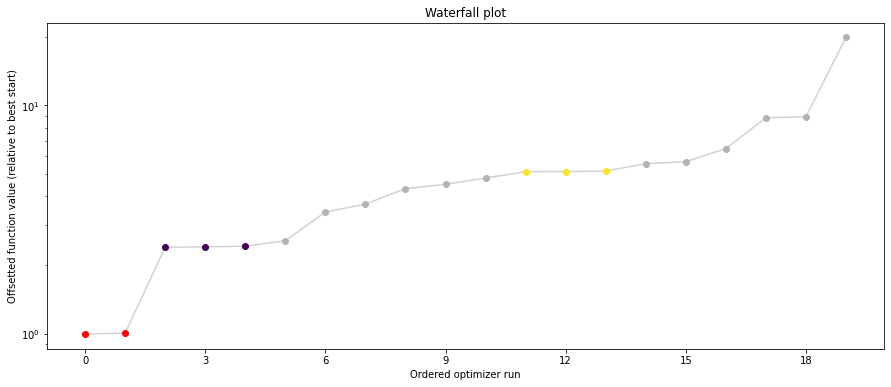

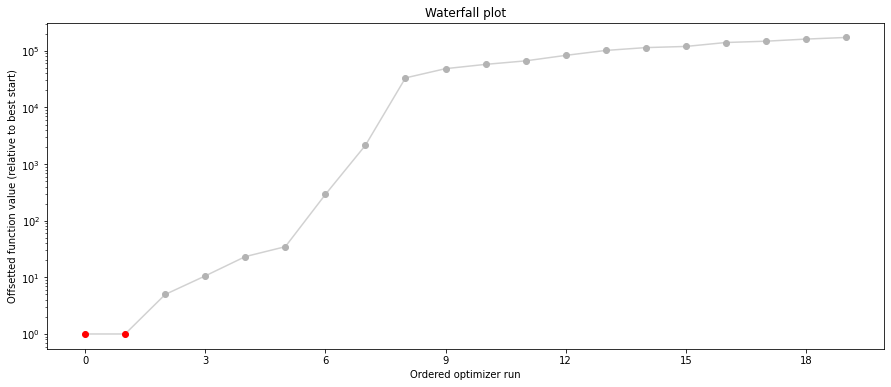

In [6]:
import pypesto.visualize

# plot separated waterfalls
pypesto.visualize.waterfall(result1_bfgs, size=(15,6))
pypesto.visualize.waterfall(result1_tnc, size=(15,6))
pypesto.visualize.waterfall(result1_dogleg, size=(15,6))

We can now have a closer look, which method perfomred better: Let's first compare bfgs and TNC, since both methods gave good results. How does the fine convergence look like?

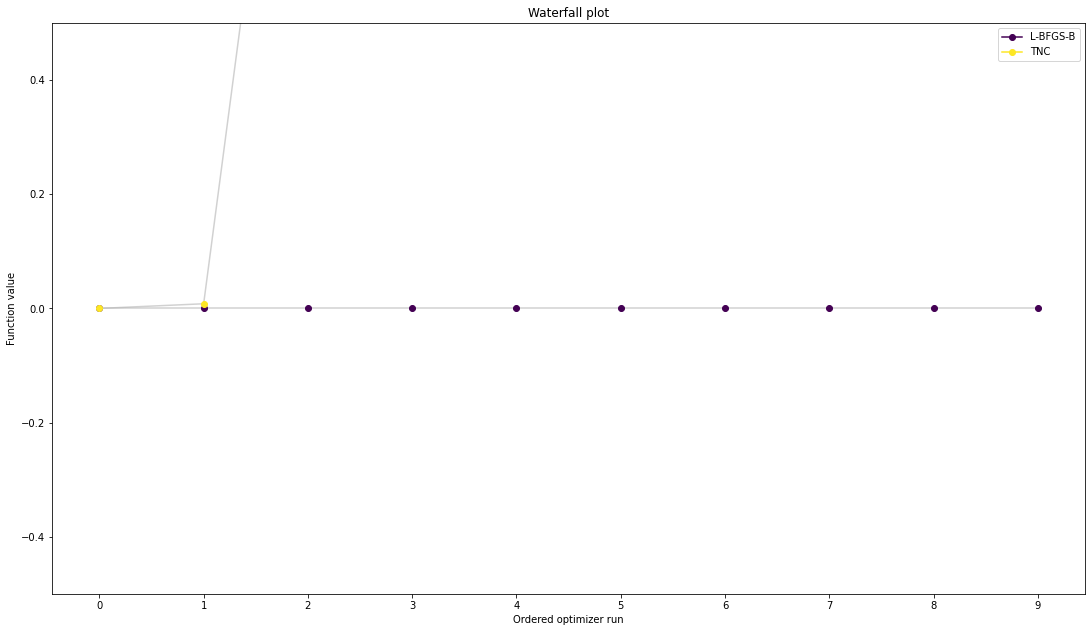

In [7]:
# plot one list of waterfalls
pypesto.visualize.waterfall([result1_bfgs, result1_tnc],
                            legends=['L-BFGS-B', 'TNC'],
                            start_indices=10,
                            scale_y='lin')

Second optimum at: 3.9865791126240384


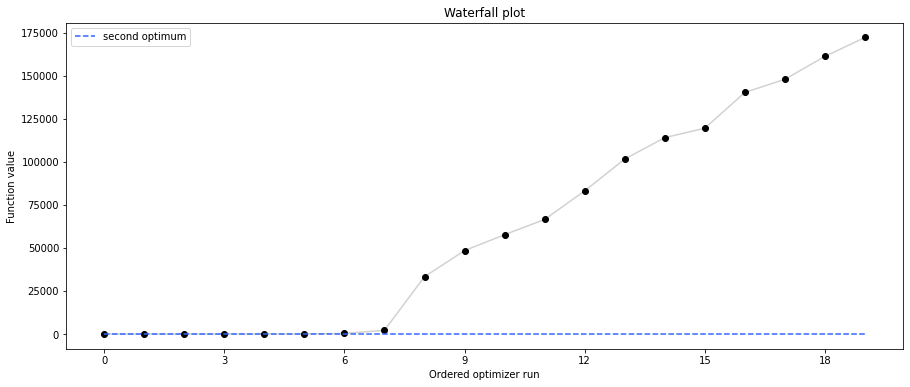

In [8]:
# retrieve second optimum
all_x = result1_bfgs.optimize_result.get_for_key('x')
all_fval = result1_bfgs.optimize_result.get_for_key('fval')
x = all_x[19]
fval = all_fval[19]
print('Second optimum at: ' + str(fval))

# create a reference point from it
ref = {'x': x, 'fval': fval, 'color': [
    0.2, 0.4, 1., 1.], 'legend': 'second optimum'}
ref = pypesto.visualize.create_references(ref)

# new waterfall plot with reference point for second optimum
pypesto.visualize.waterfall(result1_dogleg, size=(15,6), 
                            scale_y='lin', y_limits=[-1, 101],
                            reference=ref, colors=[0., 0., 0., 1.])

## Visualize parameters

There seems to be a second local optimum. We want to see whether it was also found by the dogleg method

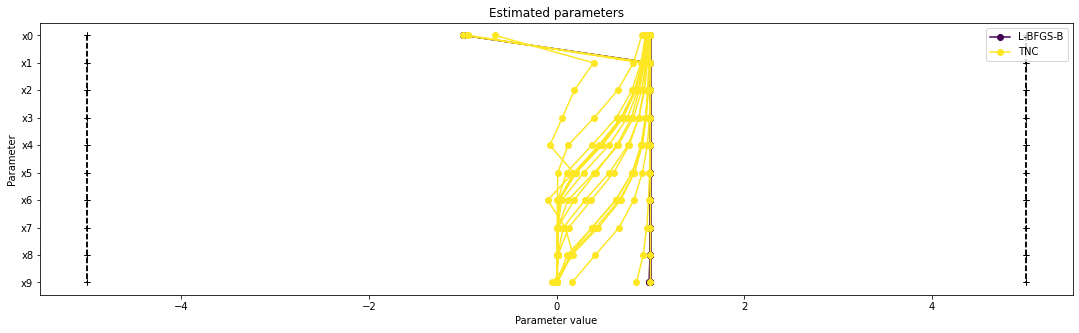

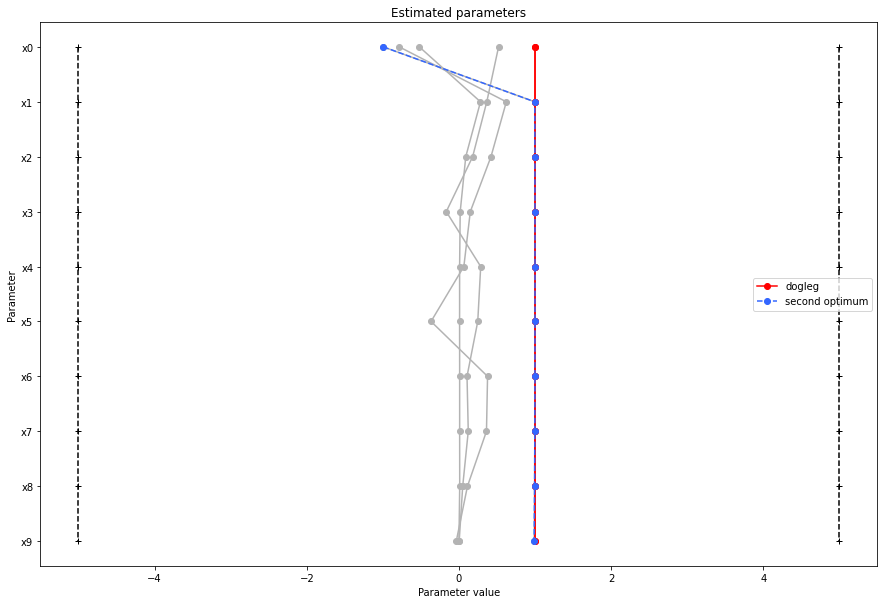

In [9]:
pypesto.visualize.parameters([result1_bfgs, result1_tnc],
                            legends=['L-BFGS-B', 'TNC'],
                            balance_alpha=False)
pypesto.visualize.parameters(result1_dogleg,
                             legends='dogleg',
                             reference=ref,
                             size=(15,10),
                             start_indices=[0, 1, 2, 3, 4, 5],
                             balance_alpha=False)

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [10]:
df = result1_tnc.optimize_result.as_dataframe(
    ['fval', 'n_fval', 'n_grad', 'n_hess', 'n_res', 'n_sres', 'time'])
df.head()

,fval,n_fval,n_grad,n_hess,n_res,n_sres,time
0,2.847035e-08,101,101,0,0,0,0.067417
1,8.139439e-03,101,101,0,0,0,0.073458
2,1.394732e+00,101,101,0,0,0,0.066997
3,1.404666e+00,101,101,0,0,0,0.067510
4,1.421427e+00,101,101,0,0,0,0.076935


### Optimizer history

Let's compare optimzer progress over time.

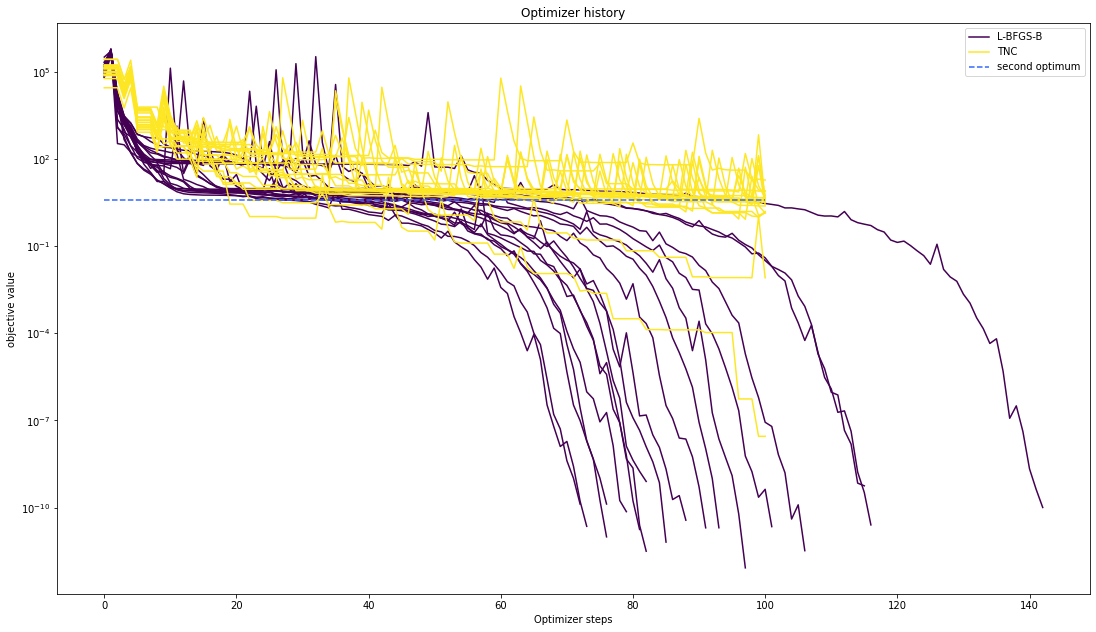

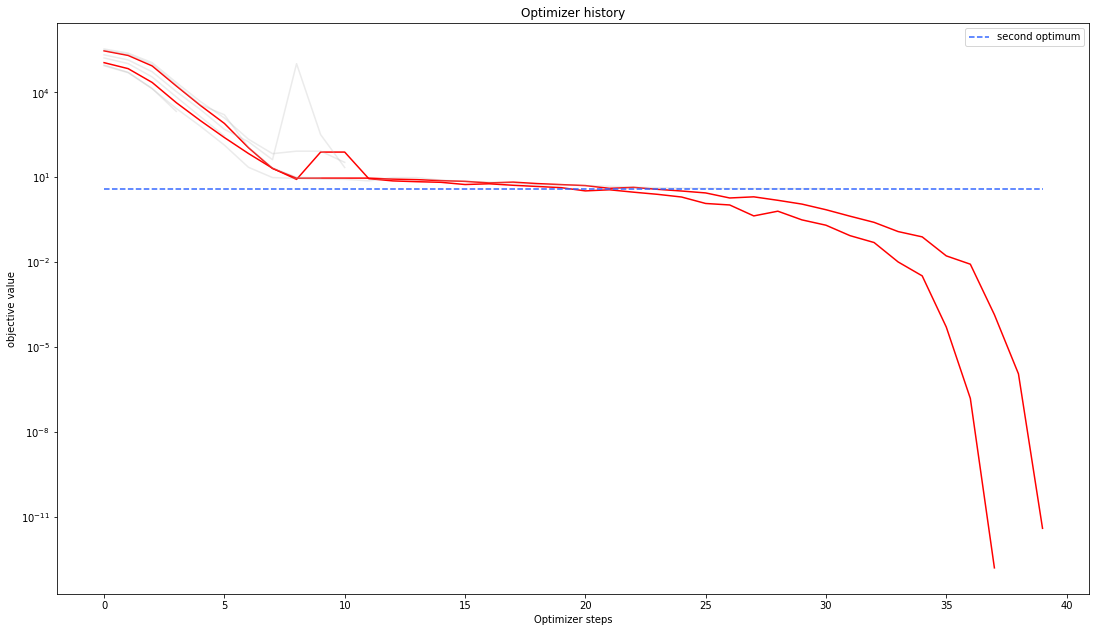

In [11]:
# plot one list of waterfalls
pypesto.visualize.optimizer_history([result1_bfgs, result1_tnc],
                                    legends=['L-BFGS-B', 'TNC'],
                                    reference=ref)
# plot one list of waterfalls
pypesto.visualize.optimizer_history(result1_dogleg,
                                    reference=ref)

We can also visualize this usign other scalings or offsets...

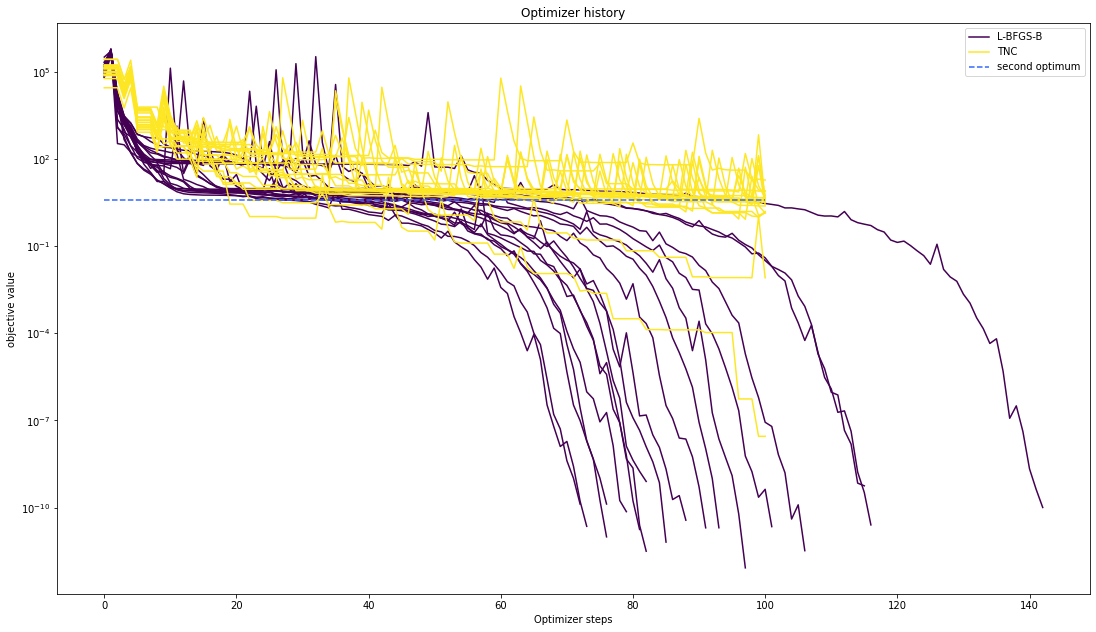

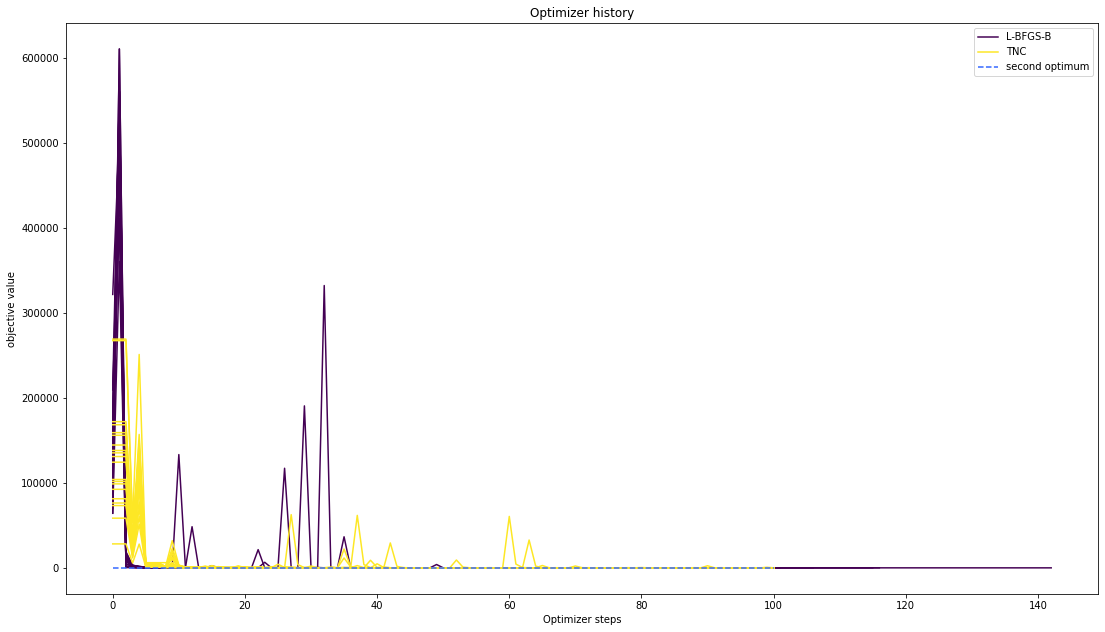

In [12]:
# plot one list of waterfalls
pypesto.visualize.optimizer_history([result1_bfgs, result1_tnc],
                                    legends=['L-BFGS-B', 'TNC'],
                                    reference=ref,
                                    offset_y=0.)

# plot one list of waterfalls
pypesto.visualize.optimizer_history([result1_bfgs, result1_tnc],
                                    legends=['L-BFGS-B', 'TNC'],
                                    reference=ref,
                                    scale_y='lin',
                                    y_limits=[-1., 11.])

## Compute profiles

The profiling routine needs a problem, a results object and an optimizer.

Moreover it accepts an index of integer (profile_index), whether or not a profile should be computed.

Finally, an integer (result_index) can be passed, in order to specify the local optimum, from which profiling should be started.

In [13]:
%%time

# compute profiles
profile_options = pypesto.ProfileOptions(min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.01)

result1_bfgs = pypesto.parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    optimizer=optimizer_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options)

# compute profiles from second optimum
result1_bfgs = pypesto.parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    optimizer=optimizer_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=19,
    profile_options=profile_options)

CPU times: user 3 s, sys: 32.2 ms, total: 3.04 s
Wall time: 3.09 s


### Visualize and analyze results

pypesto offers easy-to-use visualization routines:

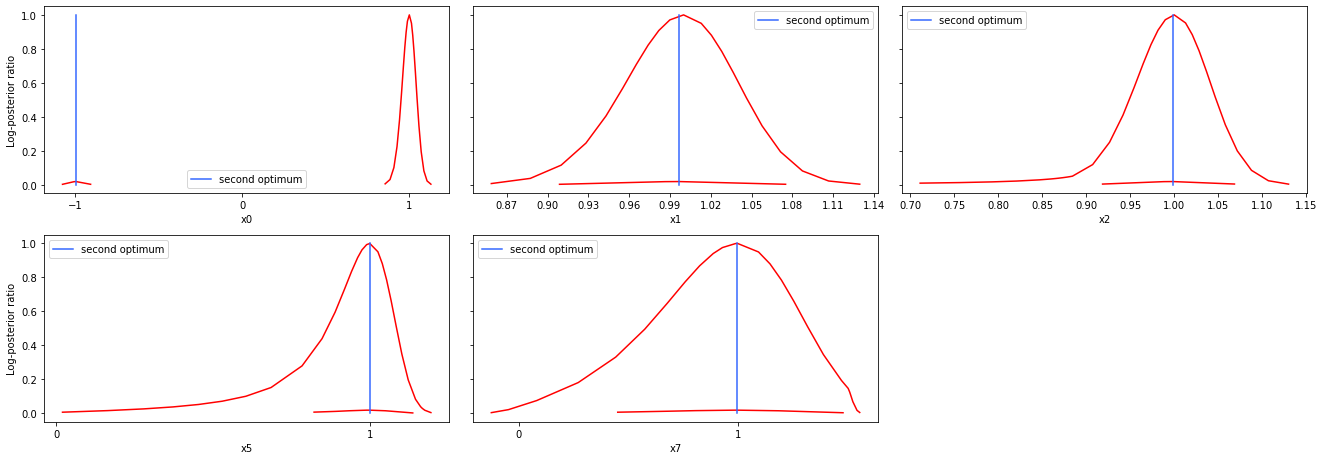

In [18]:
# specify the parameters, for which profiles should be computed
ax = pypesto.visualize.profiles(result1_bfgs, profile_indices = [0,1,2,5,7], 
                           reference=ref, profile_list_ids=[0, 1])

### Approximate profiles

When computing the profiles is computationally too demanding, it is possible to employ to at least consider a normal approximation with covariance matrix given by the Hessian or FIM at the optimal parameters.

In [15]:
%%time

result1_tnc = pypesto.profile.approximate_parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    n_steps=1000)

CPU times: user 26.3 ms, sys: 4.94 ms, total: 31.2 ms
Wall time: 25.9 ms


These approximate profiles require at most one additional function evaluation, can however yield substantial approximation errors:

In [16]:
axes = pypesto.visualize.profiles(
    result1_bfgs, profile_indices = [0,1,2,5,7], profile_list_id=0, ratio_min=0.02,
    colors=(0,0,1,1), legends="Optimization-based profile")
axes = pypesto.visualize.profiles(
    result1_tnc, profile_indices = [0,1,2,5,7], profile_list_id=2,
    colors=(1,0,0,1), ratio_min=0.03, ax=axes, legends="Local profile approximation")

TypeError: profiles() got an unexpected keyword argument 'profile_list_id'

We can also plot approximate confidence intervals based on profiles:

In [ ]:
pypesto.visualize.profile_cis(result1_bfgs, confidence_level=0.95, profile_list=2)